# データの前処理

In [1]:
%load_ext autoreload
%autoreload 2

## import

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import tensorflow as tf
import tensorflow.keras.layers as layers
# tensorflowのversion
print("tensorflow version is {}".format(tf.__version__))

tensorflow version is 2.3.0


In [3]:
np.random.seed(1)
tf.random.set_seed(1)

## データセットの生成

In [4]:
from lib.data_generator import DataGenerator
inputfilename = "./questionnaire/questionnaire_latest.csv"
dg = DataGenerator(inputfilename)
dg.generate()
# データセットへのアクセス
#dg.df_static_info_binary   # 静的情報（バイナリベクトル）
#dg.df_static_info_weight   # 静的情報（重み付きベクトル）
#dg.df_dynamic_info         # 動的情報
#dg.df_human_info           # 性格情報

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [5]:
def split_label(df):
    culm = len(df.iloc[0])-1
    return df.iloc[:,:culm], df.iloc[:,culm]

def dataset(dg):
    # trainデータとtestデータに分ける
    #train, test = train_test_split(dg, test_size=test_size)
    calm = len(dg.iloc[:])
    train = dg.iloc[:calm - 1].reset_index(drop=True)
    test  = dg.iloc[calm - 1:].reset_index(drop=True)
    
    # 特徴量と正解ラベルを分ける
    x_train, y_train = split_label(train)
    x_test, y_test = split_label(test)
    
    # 標準化する
    x_train = x_train.values
    x_test  = x_test.values
    #x_train = scale(x_train, axis=0)
    #x_test = scale(x_test, axis=0)
    
    # np.arrayに変換する
    y_train = np.array(y_train.tolist())
    y_test  = np.array(y_test.tolist())
    
    return x_train, y_train, x_test, y_test


In [6]:
# 静的情報におけるバイナリベクトルのデータセット(今回は使わない)
x_train_b, y_train_b, x_test_b, y_test_b = dataset(dg.df_static_info_binary)
#y_train_b = np.where(y_train_b != 0, 1, 0)
#y_test_b  = np.where(y_test_b != 0, 1, 0)

In [7]:
# 静的情報における重み付きベクトルのデータセット(今回はこれがメイン)
x_train_w, y_train_w, x_test_w, y_test_w = dataset(dg.df_static_info_weight)

In [8]:
# 動的情報に関するデータセット(短期トレンドモデルで用いる) 
x_train_d, y_train_din, x_test_d, y_test_din = dataset(dg.df_dynamic_info)

# 遊びレコメンドモデルの学習

## リッジ回帰

In [11]:
# 静的モデル
ridge_static = Ridge().fit(x_train_w, y_train_w)
x_train_pred = ridge_static.predict(x_train_w)
x_test_pred = ridge_static.predict(x_test_w)

In [12]:
# 静的モデルの性能評価
rank = []
for i in range(len(x_test_pred)):
    rank.append(rankdata(x_test_pred[i]))
print("output  : {}".format(x_test_pred.round(4)))
print("ranking : {}".format(rank))
print("y_label : {}".format(y_test_w.round(4)))

output  : [[-0.0367  0.1836 -0.029   0.2567  0.0085  0.2755  0.1043  0.2371]]
ranking : [array([1., 5., 2., 7., 3., 8., 4., 6.])]
y_label : [[0.    0.625 0.    0.375 0.    0.    0.    0.   ]]


In [13]:
# 静的モデルのパラメータ保存
with open('./model/static_model.pickle','wb') as f_static:
    pickle.dump(ridge_static, f_static)

------------------------------

In [14]:
# 動的モデルデータセット
x_train_din = np.hstack((x_train_pred, x_train_d[:,:2]))
x_test_din  = np.hstack((x_test_pred, x_test_d[:,:2]))

In [35]:
# 動的モデルの性能評価
kf = KFold(n_splits=len(x_train_din), random_state=True, shuffle=True) # n_splits=len(x_train_din)
predict = []
score = []
b = []
for train_index, test_index in kf.split(x_train_din):
    X_train, X_test = x_train_din[train_index], x_train_din[test_index]
    y_train, y_test = y_train_din[train_index], y_train_din[test_index]
    ridge_dynamic = RidgeClassifier().fit(X_train, np.argmax(y_train,axis=1))
    b.append(ridge_dynamic.predict(X_train))
    #predict.append(ridge2.predict(X_test))
    score.append(ridge_dynamic.score(X_test,np.argmax(y_test, axis=1)))
print("{}人に1人が満足度を感じるモデル性能".format((1//np.mean(score))))
print(np.mean(score))

3.0人に1人が満足度を感じるモデル性能
0.3181818181818182


In [16]:
# 動的モデルのパラメータ保存
ridge_dynamic = RidgeClassifier().fit(x_train_din, np.argmax(y_train_din,axis=1))
with open('./model/dynamic_model.pickle','wb') as f_dynamic:
    pickle.dump(ridge_dynamic, f_dynamic)

# 遊びに行くメンバーのレコメンドモデルの提案

## k-means(データ解析用)

In [101]:
X = dg.df_human_info
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300,
         tol=0.0001,precompute_distances='auto', verbose=0,
         random_state=None, copy_x=True, n_jobs=1)
kmeans.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:934: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  "effect", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=3, n_jobs=1, precompute_distances='auto')

In [102]:
print(kmeans.predict(X))
results = pd.DataFrame({'classter': kmeans.predict(X)})

[0 2 2 2 0 2 1 0 1 2 2 0 2 1 0 1 0 2 2 1 1 2 2 2 2 2 1 2 0 0 2 0 1 0 1 0 2
 2 2 2 1 1 1 1 0]


In [103]:
df_classtor_stat = dg.df_human_info
df_classtor_stat['label'] = results

In [104]:
df_classtor_stat.groupby('label').agg([np.mean, np.median, np.var, np.std]).T

label                                 0.0       1.0       2.0
通常，自分から話を始めることはない        mean    2.090909  3.615385  2.000000
                         median  2.000000  3.000000  2.000000
                         var     1.690909  1.256410  1.473684
                         std     1.300350  1.120897  1.213954
どちらかというと控えめで，静かな性格である    mean    1.272727  3.692308  3.500000
                         median  1.000000  4.000000  4.000000
                         var     1.818182  0.730769  1.105263
                         std     1.348400  0.854850  1.051315
深く考えるより，すぐに行動したい         mean    4.000000  4.000000  2.150000
                         median  4.000000  4.000000  2.000000
                         var     0.600000  0.833333  1.081579
                         std     0.774597  0.912871  1.039990
リーダーとして皆を引っ張っていきたい       mean    2.181818  2.000000  1.550000
                         median  2.000000  2.000000  1.000000
                         var     2.563636  2.500000  2.155263
                         std     1.601136  1.581139  1.468081
近くでイベントがあれば参加するほうだ       mean    2.090909  2.461538  2.450000
                         median  2.000000  3.000000  3.000000
                         var     2.690909  0.769231  0.892105
                         std     1.640399  0.877058  0.944513
どちらかというと，開放的で，陽気なタイプだと思う mean    2.454545  1.384615  2.050000
                         median  3.000000  1.000000  2.000000
                         var     2.872727  1.589744  1.102632
                         std     1.694912  1.260850  1.050063

## T-SNE(データ解析用)

In [107]:
X = dg.df_human_info
tsne = TSNE(n_components=3, perplexity=5,).fit_transform(X.iloc[:,[0,1,2]])
print(tsne.shape)

(45, 3)


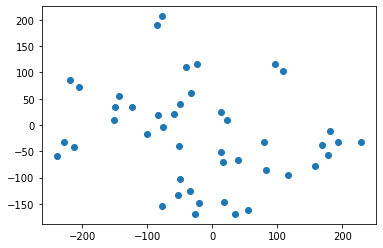

In [96]:
plt.scatter(tsne[:,0],tsne[:,1])

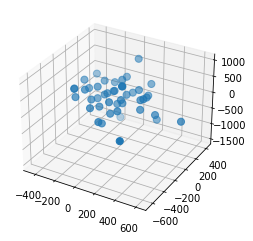

In [108]:
# 3D可視化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne[:,0], ys=tsne[:,1], zs=tsne[:,2], zdir='z', s=50, c=None, depthshade=True)

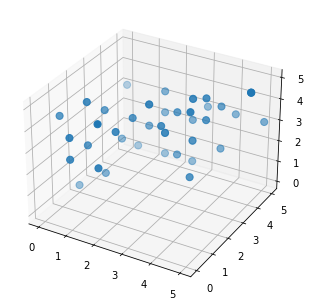

In [116]:
# 3D可視化
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs=X.iloc[:,0], ys=X.iloc[:,1], zs=X.iloc[:,2], zdir='z', s=50, c=None, depthshade=True)
plt.show()

k-meansの結果から，dg.df_human_info(性格診断データ)の\[ 0, 1, 2, 5 \]のデータのみで友達レコメンドができそうな事がわかった．

## 遊びに行くメンバーのレコメンドモデルの提案

### データの整理

In [14]:
data = dg.df_human_info.iloc[:,[0,1,2,5]]
data["ID"] = range(len(data))
data = data.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
rows = len(data[:])
train = data[:rows - 1]
test  = data[rows - 1:]

### プロットの距離(ユークリッド距離)とベクトルの類似度(コサイン類似度)の計算

In [16]:
euclid = np.zeros((len(train[:]),2))
cos_simi = np.zeros((len(train[:]),2))
for i in range(len(train[:])):
    euclid[i,0] = np.linalg.norm(train[i,:4]-test[0,:4])
    euclid[i,1] = train[i,4]
    cos_simi[i,0] = cosine_similarity(train[i:i+1,:4],test[0:1,:4]) 
    cos_simi[i,1] = train[i,4]

### 評価値の算出

ユークリッド距離は，値が0に近いほどプロット間の距離が近い(最適)とされており，コサイン類似度は，値が1に近いほどプロットのベクトルが類似している(最適)とされている．  
したがって，正規化したコサイン類似度の値から，正規化したユークリッド距離の値を引くことで，プロット間の距離とプロットのベクトルの類似度を考慮した値を導出することが可能である(はず)．

In [17]:
mm = MinMaxScaler()

mm.fit(euclid[:,0].reshape(len(euclid[:,0]),1))
euclid[:,0:1] = mm.transform(euclid[:,0].reshape(len(euclid[:,0]),1))

mm.fit(cos_simi[:,0].reshape(len(cos_simi[:,0]),1))
cos_simi[:,0:1] = mm.transform(cos_simi[:,0].reshape(len(cos_simi[:,0]),1))

In [18]:
eval_val = euclid
eval_val[:,0] = cos_simi[:,0]-euclid[:,0]
eval_val[:,1] = cos_simi[:,1]
eval_sort = eval_val[eval_val[:,0].argsort(),:][::-1].round(4)

In [19]:
dict(ID0=int(eval_sort[0,1]),
     ID1=int(eval_sort[1,1]),
     ID2=int(eval_sort[2,1]),
     ID3=int(eval_sort[3,1]),
     ID4=int(eval_sort[4,1]))

{'ID0': 40, 'ID1': 30, 'ID2': 0, 'ID3': 18, 'ID4': 41}

# 不採択になったモデル

## MLP

### モデルの実装

In [25]:
def create_model():
    inputs = layers.Input((8,))
    x = layers.Dense(2, activation="sigmoid")(inputs)
    x = layers.Dense(8, activation="sigmoid")(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

def main():    
    model = create_model()
    loss = tf.keras.losses.MeanSquaredError()
    acc = tf.keras.losses.MeanSquaredError()
    optim = tf.keras.optimizers.Adam()

    # train
    model.compile(optimizer=optim, loss=loss, metrics=[acc])
    model.fit(x_train_w, y_train_w, validation_data=(x_test_w, y_test_w), epochs=20, batch_size=4)

    # eval
    val_loss, val_acc = model.evaluate(x_test_w, y_test_w, batch_size=4)
    
    return model 

if __name__ == "__main__":
    model = main()

Epoch 1/20
10/10 [==============================] - 0s 15ms/step - loss: 0.1748 - mean_squared_error: 0.1740 - val_loss: 0.1617 - val_mean_squared_error: 0.1637
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - val_loss: 0.1600 - val_mean_squared_error: 0.1620
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1713 - mean_squared_error: 0.1722 - val_loss: 0.1583 - val_mean_squared_error: 0.1603
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1696 - mean_squared_error: 0.1692 - val_loss: 0.1566 - val_mean_squared_error: 0.1585
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1679 - mean_squared_error: 0.1677 - val_loss: 0.1550 - val_mean_squared_error: 0.1569
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1663 - mean_squared_error: 0.1664 - val_loss: 0.1535 - val_mean_squared_error: 0.1553
Epoch 7/20
10/10 [=====================

### 結果の確認

In [26]:
raw = 0

In [27]:
print(model.predict(x_test_w[raw:raw+1,:]))

[[0.33778268 0.506331   0.48925483 0.4798966  0.28250325 0.47609758
  0.4129015  0.35314476]]


In [28]:
print(y_test_w[raw,:])

[0.  0.  0.4 0.  0.  0.7 1.  0. ]


## ランダムフォレスト

In [112]:
clf = RandomForestClassifier(max_depth=4, random_state=0)

In [113]:
a = []
b = []
for i in range(len(y_train_din)):
    a.append(np.str(y_train_din[i]))
for j in range(len(y_test_din)):
    b.append(np.str(y_test_din[j]))

In [114]:
# original
clf.fit(x_train_din, a)

# pca
#clf.fit(x_train_pca,y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [115]:
print(clf.feature_importances_)

[0.03351504 0.07109923 0.04766469 0.05584132 0.         0.12373967
 0.0997709  0.02889126 0.18324612 0.20232368 0.15390808]


In [116]:
dg.GENRE_LIST

['アウトドア（マリンスポーツ・釣り・BBQ・登山・ハイキングなど）',
 'エンタメ（ボウリング場・カラオケ・ゲームセンターなど）',
 'スポーツ（ボルダリング・ゴルフ・サイクリング・ジム・ヨガなど）',
 '観光（観光名所巡り・日帰り温泉・食べ歩きなど）',
 '遊園地・動物園・水族館・海水浴場',
 '友達との飲み会（外飲み・飲み歩きなど）',
 '外での買い物（アウトレットなど）',
 'ショー・展示・催し（映画館・ミュージカル・博物館・美術館など）',
 'なし']

In [117]:
clf.classes_ 

array(['[0 0 0 0 0 0 0 1]', '[0 0 0 0 0 0 1 0]', '[0 0 0 0 0 1 0 0]',
       '[0 0 0 1 0 0 0 0]', '[0 0 1 0 0 0 0 0]', '[0 1 0 0 0 0 0 0]',
       '[1 0 0 0 0 0 0 0]'], dtype='<U17')

In [118]:
# original
print(clf.predict(x_test_din))
print(clf.score(x_test_din, b))

# pca
#clf.score(x_test_pca,y_test)

['[0 0 0 0 0 1 0 0]' '[0 0 0 0 0 0 1 0]' '[0 0 0 1 0 0 0 0]'
 '[0 0 0 0 0 1 0 0]' '[0 0 0 0 0 1 0 0]']
0.0


## 主成分分析(データ解析用)

In [10]:
X = dg.df_human_info
X = scale(X, axis=0)
pca = PCA(n_components=3)
pca.fit(X)
x_pca = pca.transform(X)
sum(pca.explained_variance_ratio_)

0.7081007695172404

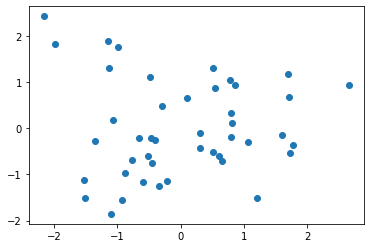

In [11]:
plt.scatter(x_pca[:,1],x_pca[:,2])

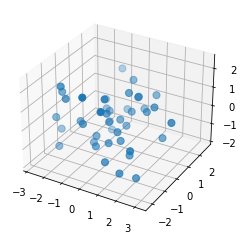

In [12]:
# 3D可視化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x_pca[:,0], ys=x_pca[:,1], zs=x_pca[:,2], zdir='z', s=50, c=None, depthshade=True)